# Group 22 Final Report

### Group Members:

Kaiser Ninomiya (41514506)

Patrick Cui (39674692)

Uday Kapoor (21201249)

Viet Ngo (71724082)

## Gender Wage Disparities in the United States: A Comparative Analysis

### Table of Contents

- [Introduction](#Introduction)
- [Methods and Results](#Methods-and-Results)
    - [Data Wrangling](#Data-Wrangling)
    - [Plotting of Relevant Variables](#Plotting-of-Relevant-Variables)
    - [Hypothesis Testing](#)
- [References](#References)

# Introduction

The proposed project aims to investigate gender wage disparities in the United States using a dataset containing information on various demographic and employment-related variables. The primary question we seek to answer is whether there is a significant difference in wages between male and female workers, specifically whether male workers more likely to earn more than their female counterparts. We will focus on the hourly wage as our main variable of interest to compare across the two genders. By analyzing this dataset, we aim to shed light on existing gender wage gaps and assess the potential impact of such disparities.
Our project aims to investigate gender wage disparities in the United States using a dataset containing information on various demographic and employment-related variables. We seek to answer whether there is a significant difference in wages between male and female workers.

For this report, we will use the mean as the parameter of interest. Although the distribution of wages is known to be right-skewed, the median would be a better choice. However, we do not yet have the tool to use asymptotic method on the median, hence our choice of the mean. From our question, we formally state the hypotheses as follow:
$$H_{0}: \mu_{\text{male}} = \mu_{\text{female}}$$ $$H_{1}: \mu_{\text{male}} > \mu_{\text{female}}$$ $$\text{Confidence level: 0.95}$$
Where $\mu_{\text{male}}$ and $\mu_{\text{female}}$ are the mean wage for men and women respectively. We choose the confidence level to be 0.95 because it is a common value used for hypothesis testing. In addition, we are not making any high-risk decisions based on the result of this test so a higher p-value is not needed.

# Methods and Results

## Data Wrangling

In [51]:
library(infer)
library(repr)
library(readr)
library(tidyverse)
library(RColorBrewer)

library(cowplot)
library(datateachr)
library(digest)
library(taxyvr)
library(broom)
library(testthat)
library(infer)

We have successfully imported and cleaned the dataset, ensuring that the data is in a tidy format for analysis. We have also plotted the raw data, specifically examining the distribution of hourly wages for male and female workers. In the preliminary analysis, we observed that there is a clear difference in the distribution of hourly wages between males and females.

In [52]:
raw_data <- read_csv('https://github.com/AVietCong/stat201-group22-project/raw/main/Gender_Pay_Gap_dataset.csv')
raw_data$occupation <- colnames(raw_data[,106:127])[apply(raw_data[,106:127], 1, which.max)]

filtered_data <- select(raw_data, sex, race, hrwage, incwage, sch, wkswork1, uhrswork, potexp, occupation) %>%
    mutate(sex = as.factor(sex),
           race = as.factor(race),
           hrwage = as.double(hrwage),
           incwage = as.double(incwage),
           sch = as.double(sch),
           wkswork = as.integer(wkswork1),
           uhrswork = as.integer(uhrswork),
           potexp = as.integer(potexp),
           occupation = as.factor(occupation))

head(filtered_data)
print("Table 1.1 - Filtered gender paygap table")

Rows: 53790 Columns: 129
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): adj_occ2name
dbl (127): year, serial, numprec, gq, region, statefip, metro, metarea, coun...
lgl   (1): farm

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sex race hrwage incwage sch wkswork1 uhrswork potexp occupation             
1 1   1    24.913 57000   14  52       44       42     healthcare             
2 1   1    31.000 62000   13  50       40       40     constructextractinstall
3 1   3    21.635 45000   12  52       40       26     architect              
4 1   1    12.821 28000   12  52       42       23     manager                
5 1   1    21.250 42500   12  50       40       17     transport              
6 1   1    21.875 35000   11  40       40       18     constructextractinstall
  wkswork
1 52     
2 50     
3 52     
4 52     
5 50     
6 40

[1] "Table 1.1 - Filtered gender paygap table"


We have narrowed down the dataset to focus only on the variables of interest: namely sex, race, hourly wage(hrwage), total income (incwage), schooling years (sch), occupation, weeks worked (wkswork1), and usual hours worked (uhrswork).

In [53]:
pay_data <- filtered_data %>%
    mutate(sex = fct_recode(sex, 'male' = '1', 'female' = '2'),
           race = fct_recode(race, 'White' = '1', 'Black' = '2', 'Hispanic' = '3', 'Other' = '4'),
           education_level = case_when(sch == 0 ~ 'None',
                                       sch < 12 ~ 'Incomplete Schooling', 
                                       sch == 12 ~ 'Highschool',
                                       sch == 13 ~ 'College',
                                       sch == 14 ~ 'Associate Degree',
                                       sch <= 16 ~ 'BA',
                                       sch <= 18 ~ 'Advanced Degree')) %>%
    select(-sch)
head(pay_data)
print("Table 1.2 - Gender paygap table with education level")

sex  race     hrwage incwage wkswork1 uhrswork potexp occupation             
1 male White    24.913 57000   52       44       42     healthcare             
2 male White    31.000 62000   50       40       40     constructextractinstall
3 male Hispanic 21.635 45000   52       40       26     architect              
4 male White    12.821 28000   52       42       23     manager                
5 male White    21.250 42500   50       40       17     transport              
6 male White    21.875 35000   40       40       18     constructextractinstall
  wkswork education_level     
1 52      Associate Degree    
2 50      College             
3 52      Highschool          
4 52      Highschool          
5 50      Highschool          
6 40      Incomplete Schooling

[1] "Table 1.2 - Gender paygap table with education level"


Here we reassign the factors be more readable.

In [54]:
print("Count of missing values by column wise")
sapply(pay_data, function(x) sum(is.na(x)))

[1] "Count of missing values by column wise"


sex            race          hrwage         incwage        wkswork1 
              0               0               0               0               0 
       uhrswork          potexp      occupation         wkswork education_level 
              0               0               0               0               0

In [55]:
for (x in list("male", "female")) {
    cat("mean for " , x , ": ", mean(subset(pay_data, sex==x)$hrwage), "\n")
    cat("median for ",x,": ", median(subset(pay_data, sex==x)$hrwage), "\n")
    cat("sd for ",x,": ", sd(subset(pay_data, sex==x)$hrwage), "\n", "\n")
}

mean for  male :  28.844 
median for  male :  21.635 
sd for  male :  221.4 
 
mean for  female :  21.924 
median for  female :  17.308 
sd for  female :  23.502 
 


## Plotting of relevant variables

### Demographics

In [56]:
sex_summary <- pay_data |>
    group_by(sex) |>
    summarise(count = n())
sex_summary
print("Table 2.1 - Sample sizes of men and women in the dataset")

sex    count
1 male   27225
2 female 26565

[1] "Table 2.1 - Sample sizes of men and women in the dataset"


[1] "Figure 2.2 - Number of men and women in the dataset"


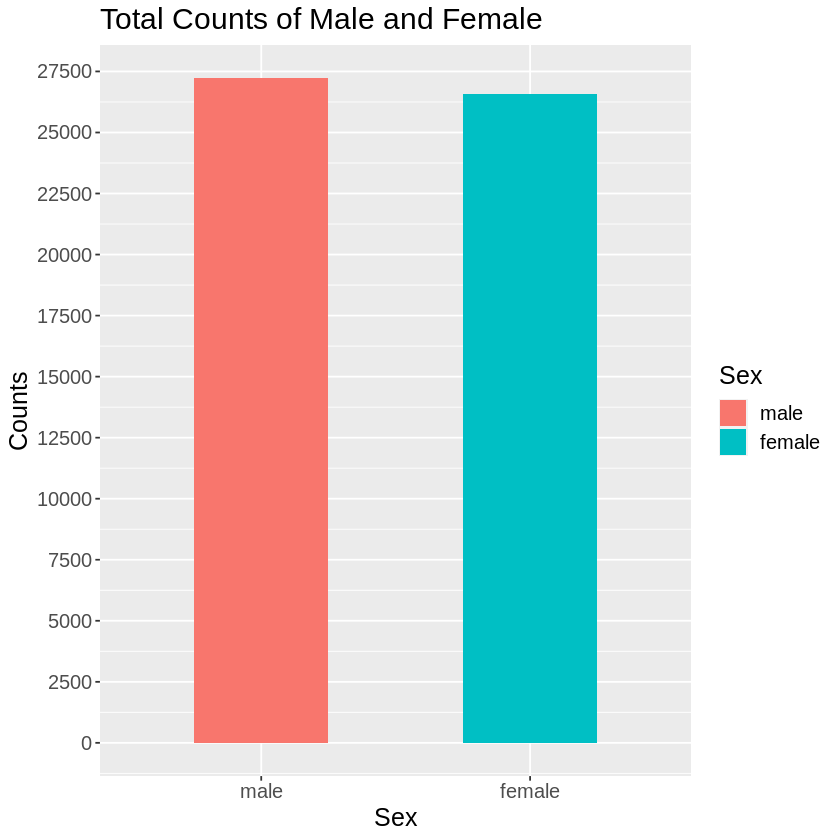

In [57]:
sex_plot <- sex_summary |>
    ggplot(aes(x = sex, y = count, fill = sex)) +
    geom_bar(stat = "identity", width = 0.5) +
    scale_y_continuous(breaks=seq(0, 27500, by = 2500)) +
    labs(x = "Sex", y = "Counts", fill = "Sex") +
    theme(text = element_text(size = 15)) +
    ggtitle("Total Counts of Male and Female")
    
sex_plot
print("Figure 2.2 - Number of men and women in the dataset")

We can see that the number of man and woman in the survey are roughly equal and that the sample size for each group is quite large.

## Hourly Wage 

In [58]:
hrwage_summary <- pay_data %>%
    group_by(sex) %>%
    summarize(mean_wage = mean(hrwage))
hrwage_summary

sex    mean_wage
1 male   28.844   
2 female 21.924

Warning message:
“Removed 1186 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 4 rows containing missing values (geom_bar).”


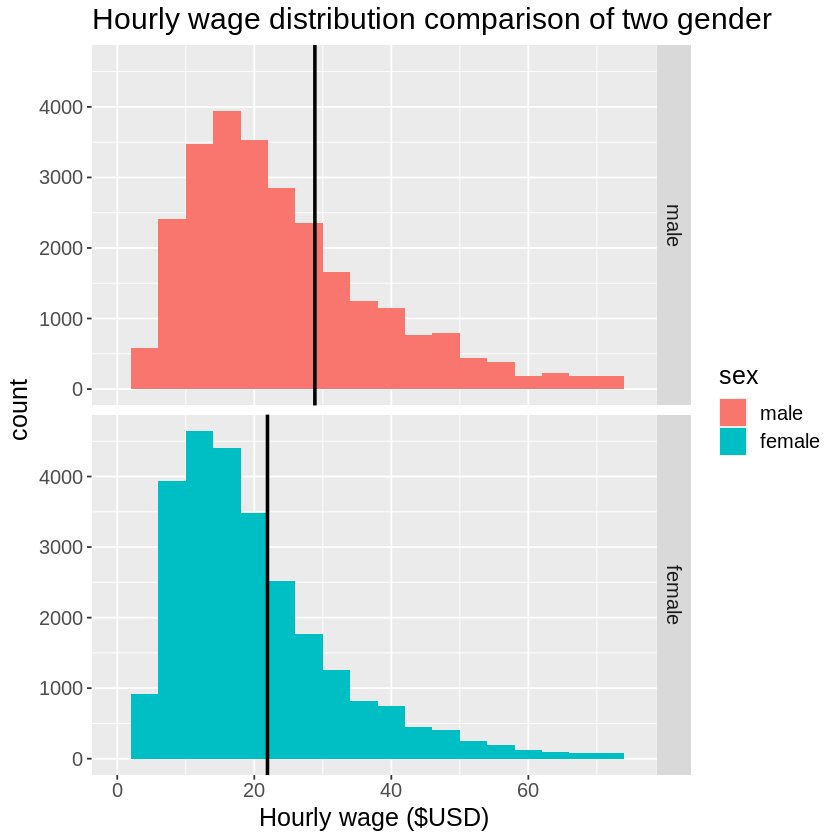

In [59]:
hrwage_plot <- pay_data %>%
  ggplot() +
  geom_histogram(aes(x = hrwage, fill = sex), binwidth = 4) +
  geom_vline(data = hrwage_summary, mapping = aes(xintercept = mean_wage), size = 1) +
  facet_grid(vars(sex)) + 
  xlim(0, 75) + xlab("Hourly wage ($USD)") + 
  ggtitle("Hourly wage distribution comparison of two gender") +
  theme(text = element_text(size = 15))
hrwage_plot

From the table and plot above, we can see that the mean wage for men is higher than women for this sample, at around $7 more.

## Hypothesis Testing - Asymptotic Method

In [60]:
data <- pay_data[, c("sex", "hrwage")]

test <- t.test(hrwage ~ sex, data = data) %>%
    tidy()
test

estimate estimate1 estimate2 statistic p.value   parameter conf.low conf.high
1 6.9196   28.844    21.924    5.1273    2.959e-07 27853     4.2744   9.5648   
  method                  alternative
1 Welch Two Sample t-test two.sided

Here we select the two relevant columns and perform a two-sample t-test using the `t.test` function. We can rely on the Central Limit Theorem to perform a t-test here because our estimator is indeed a random sum of compononents (hourly wage). In addtion, the sample size for both groups is very large to compensate for the fact that the sample distribution is not normal.

In [61]:
set.seed(2345)
sample <- 
    data %>%
    group_by(sex) %>%
    sample_n(size = case_when(sex == "male" ~ 200,
                              sex == "female" ~ 200),
             replace = FALSE) %>%
    ungroup()
head(sample)

sex  hrwage
1 male 24.556
2 male 44.231
3 male 19.231
4 male 96.154
5 male 72.115
6 male 19.118

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



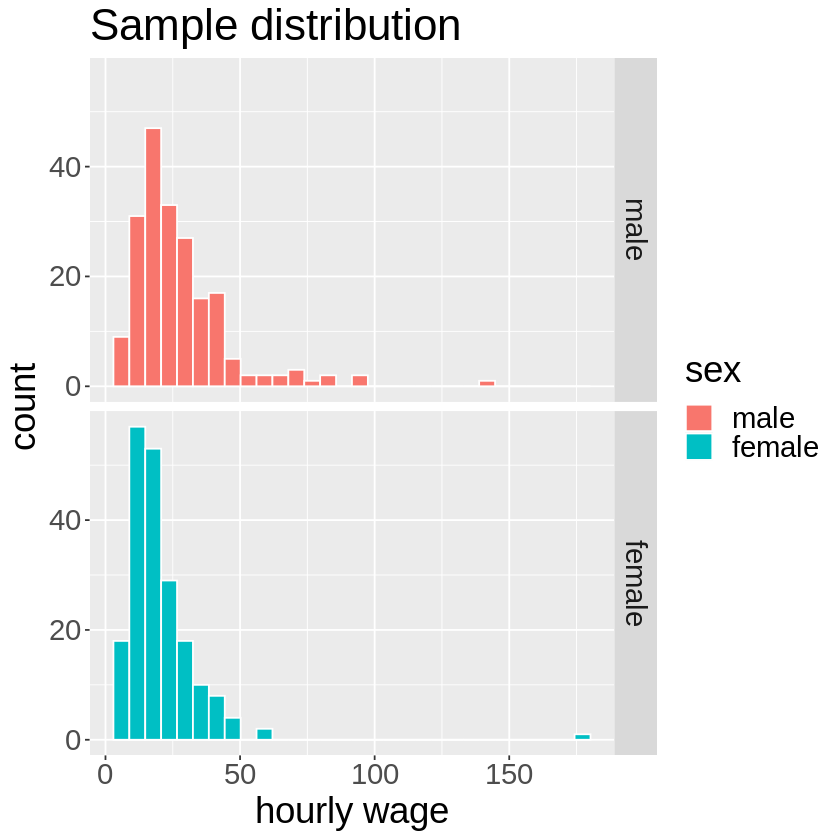

In [76]:
samp_dist_plot <- 
    sample %>% 
    ggplot() + 
    geom_histogram(aes(x = hrwage, fill = sex), color = 'white') +
    facet_grid(vars(sex)) + 
    theme(text = element_text(size = 22)) +
    ggtitle("Sample distribution") + 
    xlab("hourly wage")

samp_dist_plot

In [63]:
sample_summary <- 
    sample %>%
    group_by(sex) %>%
    summarise(sample_mean = mean(hrwage),
             sample_std_error = sd(hrwage)/sqrt(n()))
sample_summary

sex    sample_mean sample_std_error
1 male   27.389      1.2740          
2 female 20.324      1.0692

In [64]:
ci = 0.95

male_mean <- sample_summary$sample_mean[1]
male_var <- sample_summary$sample_std_error[1]^2
female_mean <- sample_summary$sample_mean[2]
female_var <- sample_summary$sample_std_error[2]^2

parking_clt_ci <- 
    tibble(lower_ci = (male_mean - female_mean - qnorm(1- (1-ci)/2) * sqrt(female_var + male_var)),
           upper_ci = (male_mean - female_mean + qnorm(1- (1-ci)/2) * sqrt(female_var + male_var)))

head(parking_clt_ci)

lower_ci upper_ci
1 3.8055   10.325

In [65]:
t_test_summary <- sample %>%
    group_by(sex) %>%
    summarise(
        n = n(),
        x_bar = mean(hrwage),
        sd = sd(hrwage)
    ) %>% 
  pivot_wider(names_from = sex, values_from = c(n, x_bar, sd)) %>% 
  mutate(
    mean_diff = x_bar_male - x_bar_female
  )

t_test_summary <- t_test_summary %>%
mutate(null_std_error = sqrt((sd_male^2 / n_male) + (sd_female^2 / n_female)))

t_test_summary <- 
    t_test_summary %>% 
    mutate(p_value = 2 * pt(mean_diff/null_std_error, df=n_male+n_female-1, lower.tail=FALSE))

t_test_summary

n_male n_female x_bar_male x_bar_female sd_male sd_female mean_diff
1 200    200      27.389     20.324       18.017  15.121    7.0654   
  null_std_error p_value  
1 1.6632         2.687e-05

In [66]:
t_test <- 
    tidy(t.test(sample %>% filter(sex == "male") %>% pull(hrwage),
           sample %>% filter(sex == "female") %>% pull(hrwage)))

t_test

estimate estimate1 estimate2 statistic p.value    parameter conf.low
1 7.0654   27.389    20.324    4.248     2.7058e-05 386.37    3.7953  
  conf.high method                  alternative
1 10.335    Welch Two Sample t-test two.sided

In [67]:
diff_in_means <- sample |>
    specify(formula = hrwage ~ sex) |>
    generate(reps = 10000, type = "bootstrap") |>
    calculate(stat = "diff in means", order = c("male", "female"))

head(diff_in_means)

replicate stat   
1 1          7.9082
2 2          7.7799
3 3          7.8051
4 4          7.6291
5 5          6.5792
6 6         10.7240

In [68]:
#Calculating confidence interval for the bootstrap sampling distribution
bootstrap_ci <- diff_in_means |> 
  get_confidence_interval(level = 0.95, type = "percentile")
bootstrap_ci

lower_ci upper_ci
1 3.7824   10.343

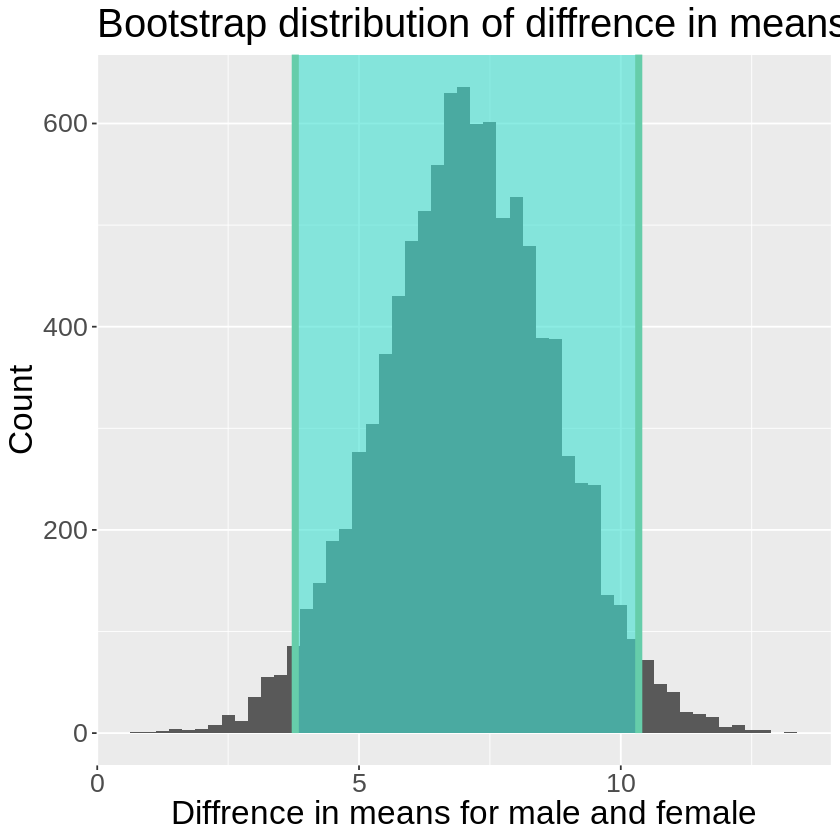

In [69]:
bootstrap_dist <- diff_in_means |>
    ggplot(aes(x = stat)) +
    geom_histogram(binwidth = 0.25) +
    labs(x = "Diffrence in means for male and female", y = "Count") +
    ggtitle("Bootstrap distribution of diffrence in means for male and female") +
    theme(text = element_text(size = 20)) +
    shade_confidence_interval(endpoints = bootstrap_ci)

bootstrap_dist

In [70]:
#creating a null distirbution 
null_diff_means <- sample |>
    specify(formula = hrwage ~ sex) |>
    hypothesize(null = "independence") |>
    generate(reps = 10000, type = "permute") |>
    calculate(stat = "diff in means", order = c("male", "female"))
head(null_diff_means)

replicate stat      
1 1         -0.5649473
2 2          1.3106140
3 3         -2.1586321
4 4         -0.0097479
5 5         -0.0379924
6 6          1.3034422

In [71]:
#Computing an observed statistic
obs_diff_means <- sample %>% 
  specify(formula = hrwage ~ sex) %>% 
  calculate(stat = "diff in means", order = c("male", "female"))
obs_diff_means

stat  
1 7.0654

In [72]:
#computing p-value
options(digits = 5)

p_value <- null_diff_means %>% 
  get_p_value(obs_stat = obs_diff_means, direction = "both")
p_value
#p-value turned out to be 0.. are we sure?

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
1 0

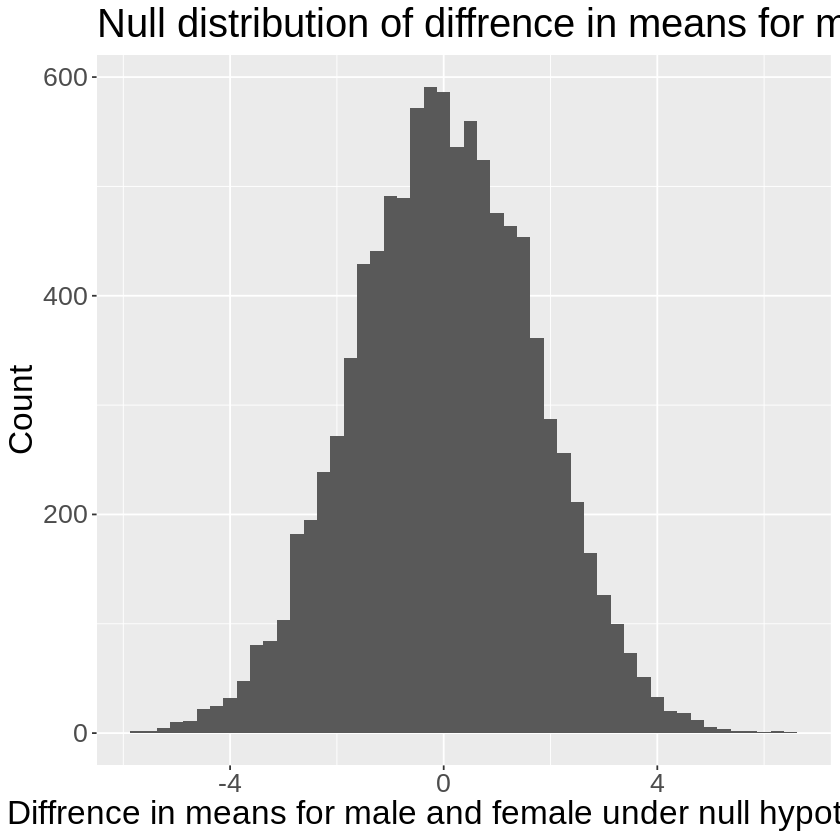

In [73]:
null_distribution <- null_diff_means |>
    ggplot(aes(x = stat)) +
    geom_histogram(binwidth = 0.25) +
    labs(x = "Diffrence in means for male and female under null hypothesis", y = "Count") +
    ggtitle("Null distribution of diffrence in means for male and female") +
    theme(text = element_text(size = 20))
null_distribution
#p-value of 0 could not be visualized..

## Reflecting on how the final report might play out

**Expected Findings:**
We expect to find that female workers earn less median hourly wages than their male counterparts. Additionally, we may anticipate uncovering variations in wage gaps across different racial groups, providing deeper insights into intersectional inequalities.

**Impact of Findings:**
Highlighting the gender wage gap can serve as a call to action for policymakers, employers, and advocates to address this pressing issue. By quantifying the existence of disparities, our study can contribute to the ongoing efforts towards gender equality in the workforce. 

**Future Question:**
Wage Gap in Different Industries: Investigating the wage gap across various industries and occupations could help identify sectors with more significant disparities and guide targeted interventions.

# References

1) Deep B. (2021). Gender Pay Gap Dataset. Kaggle. Retrieved from: https://www.kaggle.com/code/deepbdoshi/gender-pay-gap

2) Blau, F. D., & Kahn, L. M. (2017). The Gender Wage Gap: Extent, Trends, and Explanations. Journal of Economic Literature, 55(3), 789–865. http://www.jstor.org/stable/26303306

3) Pew Research Center. (March 1, 2023). Gender Pay Gap Facts. Pew Research Center. Retrieved from https://www.pewresearch.org/short-reads/2023/03/01/gender-pay-gap-facts/